# Session 6-1: Human Population Data - US Census

![ntl](./assets/humans.jpg)

Humans create [complex systems](https://en.wikipedia.org/wiki/Complex_system) and, as such, humans are incredibly difficult to study. Even counting how many people there on the planet is difficult. Many large countries - which we think have rapidly growing populations - have not had a [reliable census conducted in decades](https://www.pnas.org/doi/abs/10.1073/pnas.1715305115). Even the United States, which has a well-regarded and well-funded census, has trouble [estimating population](https://doi.org/10.1016/j.apgeog.2013.11.002). 

Human population data is very powerful. In the US, **\$2.8 Trillion** is distributed based on Census data. That's a lot of money. Human data can also be used in nefarious ways too. Governments can rig elections by stuffing districts and governments can oppress groups if they can count them. The power of This is all to say, that while human data is really important for sustainability, there are true ethical considerations when developing and using human datasets.  

In this session, we will become familiar with a few human population datasets, specifically the US Census. In doing so, we will learn about [application programming interfaces (APIs)](https://en.wikipedia.org/wiki/API).

<p style="height:1pt"> </p>

<div class="boxhead2">
    Session Topics
</div>

<div class="boxtext2">
<ul class="a">
    <li> 📌 Introduction to <span class="codeb">US Census Data</span> </li>
    <ul class="b">
        <li> Census API </li>
        <li> Merging with shapefiles </li>
        <li> Plotting Data </li>
        <li> Area Aggregation </li>
    </ul>
</div>

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

### Instructions
We will work through this notebook together. To run a cell, click on the cell and press "Shift" + "Enter" or click the "Run" button in the toolbar at the top. 

<p style="color:#408000; font-weight: bold"> 🐍 &nbsp; &nbsp; This symbol designates an important note about Python structure, syntax, or another quirk.  </p>

<p style="color:#008C96; font-weight: bold"> ▶️ &nbsp; &nbsp; This symbol designates a cell with code to be run.  </p>

<p style="color:#008C96; font-weight: bold"> ✏️ &nbsp; &nbsp; This symbol designates a partially coded cell with an example.  </p>

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

# US Census Data

<img src="./assets/income-censustract.jpg">

The US Census Bureau's "mission is to serve as the nation's leading provider of quality data about its people and economy." It collects, curates and disseminates a wide range of demographic and economic data. It's mission in enshrined the US constitution. 

The [Decadal Populationa and Housing Census](https://www.census.gov/programs-surveys/decennial-census.html#:~:text=The%20U.S.%20census%20counts%20each,of%20Representatives%20among%20the%20states.) is designed to be a complete count of people residents of the United States' territory, whereas the [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs) is conducted annually has uses a spatiall-informed sampling strategy to estimate demographic data for the entire country. Both surveys are quite useful.

With the Census, it's important to remember that how we group people changes overtime. For example, how we count Hispanic-indentifying residents of the US has [changes through time](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States_census), just as various other racial and ethnic groups. This makes tracking specific demographics through time quite difficult. Similiarly, census boundaries can change through time - again making it difficult to measure fine-grained demographic change overtime. But the Census makes a strong effort to document changes and inform users how demographic data is collected and aggregated over space and time. 

Take a moment to checkout the [graphic below](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf). 

<img src="./assets/cenus-spatial.png">

It's useful to familiarize yourself with the various spatial domains available from the Census. While it is quite easy to download US Census data, let's use the [Python Census API](https://pygis.io/docs/d_access_census.html) to check out US Census data right in our notebook. Note that this tutorial borrows from a great online resource: [PyGIS - Open Source Spatial Programming & Remote Sensing](https://pygis.io/docs/a_intro.html). Check it out!

### Importing Data from the Census API
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

Some APIs are fully public, some require free credentials (e.g. a way to authentic users), and some require a fee to use them. <br>

Please obtain a census API Key here: https://api.census.gov/data/key_signup.html <br> 

Note: I had trouble getting a key and I had to try several times with different email address to finally have one work. We are going to try to use my Census API Key (see below).

The Census API allows us to read in census data into memory. The Census, like many organizations, uses a common, yet complex, naming convention for variables. Some variables make sense (e.g. `NAME`) and others are alpha numeric. You can checkout the [US Census API User Guide](https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf). For geographic information, the Census uses [FIPS](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) codes, which are a standardize format to identify geographic adminstrative areas in the US.  

Here we are going to use the [ACS5](https://www.census.gov/data/developers/data-sets/acs-5year.html). From this we'll pull some demographic and socioeconomic data for the great state of Montana.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import rasterio
import sys

In [2]:
# Set API key 
c = Census('c2b7b1b0ee04a89666fd161e16d3e1dcec53d1b9') # My key ... please switch to your key.

Here are the variables we're going to pull from the API:
1. C17002_001E - Ratio of Income to Poverty Level in the Past 12 Months Total (e.g. total number of people in 'poverty')
1. C17002_002E - Ratio of Income to Poverty Level in the Past 12 Months <50% (e.g. 50% of poverty line)
1. C17002_003E - Ratio of Income to Poverty Level in the Past 12 Months 50-99% (e.g. 50% of poverty line)
1. B01003_001E - Total Population

You can check out the variables yourself [here](https://api.census.gov/data/2022/acs/acs5/variables.html). 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [3]:
# Make the API request
mt_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.MT.fips, # You can change the state here
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)  # You can change the year here

In [4]:
# Create a dataframe from the census data
mt_df = pd.DataFrame(mt_census)

# Show the dataframe
mt_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30,001,000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30,001,000200


In [5]:
# Check out the shape

In [ ]:
# Check out the data type

### Adding geography
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

Notice that the census data does not have any geographic information ascribed to it. We'll need to read in data directly from the Census's database of boundaries. `GeoPandas` can do this directly from the internet if the data is set up correctly. <br>

Note that I had to dive into the the [Census Tiger Product Guide](https://www.census.gov/programs-surveys/geography/guidance/tiger-data-products-guide.html) to make sense of the Census shapefiles that are online, again because they use a alphanumeric coding, not common place names.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [6]:
# Access shapefile of Montana census tracts
mt_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_30_tract.zip")
mt_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,30,029,000101,30029000101,1400000US30029000101,1.01,Census Tract 1.01,G5020,S,4688689678,89374843,+48.6403613,-114.1929769,"POLYGON ((-114.88873 48.60095, -114.88872 48.6..."
1,30,029,001101,30029001101,1400000US30029001101,11.01,Census Tract 11.01,G5020,S,1832500,6562,+48.1920787,-114.3261339,"POLYGON ((-114.33997 48.19705, -114.33982 48.1..."
2,30,029,001703,30029001703,1400000US30029001703,17.03,Census Tract 17.03,G5020,S,1813479759,24064760,+48.1102299,-114.7392721,"POLYGON ((-115.02012 48.19747, -115.02010 48.1..."
3,30,029,000903,30029000903,1400000US30029000903,9.03,Census Tract 9.03,G5020,S,3846857,48688,+48.2116106,-114.3184051,"POLYGON ((-114.33061 48.22098, -114.33057 48.2..."
4,30,029,000802,30029000802,1400000US30029000802,8.02,Census Tract 8.02,G5020,S,58392970,1352592,+48.1793434,-114.3555488,"POLYGON ((-114.39825 48.17564, -114.39824 48.1..."


In [ ]:
# What crs is the tract in?

In [ ]:
# What size in the tract file?

In [ ]:
# What are the data types of each column?

In [ ]:
# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
mt_tract = mt_tract.to_crs(epsg = 32617)
print(mt_tract.crs)
mt_tract.head()

#### GEOID
Notice that the `mt_tract` has a `GEOID` column but `mt_df` does not. So we need to combine the FIPS columns into a single GEOID that we can use to merge onto the shape file. This is pretty easy with simple string addition. 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [7]:
# Combine state, county, and tract columns together to create a new string and assign to new column
mt_df["GEOID"] = mt_df["state"] + mt_df["county"] + mt_df["tract"]

In [8]:
# Print head of dataframe
mt_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30,001,000100,30001000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30,001,000200,30001000200


In [9]:
# Remove columns we won't need later
mt_df = mt_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
mt_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30001000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30001000200


#### Check the data types
It's always good to check the data types before you merge two DataFrames to make sure that they will merge correctly.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [10]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(mt_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(mt_tract.dtypes))

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


Now merge the two DataFrames

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [11]:
# Join the attributes of the dataframes together
mt_merge = mt_tract.merge(mt_df, on = "GEOID")
mt_merge.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,30,029,000101,30029000101,1400000US30029000101,1.01,Census Tract 1.01,G5020,S,4688689678,89374843,+48.6403613,-114.1929769,"POLYGON ((-114.88873 48.60095, -114.88872 48.6...","Census Tract 1.01, Flathead County, Montana",821.0,61.0,106.0,860.0
1,30,029,001101,30029001101,1400000US30029001101,11.01,Census Tract 11.01,G5020,S,1832500,6562,+48.1920787,-114.3261339,"POLYGON ((-114.33997 48.19705, -114.33982 48.1...","Census Tract 11.01, Flathead County, Montana",3165.0,118.0,133.0,3165.0
2,30,029,001703,30029001703,1400000US30029001703,17.03,Census Tract 17.03,G5020,S,1813479759,24064760,+48.1102299,-114.7392721,"POLYGON ((-115.02012 48.19747, -115.02010 48.1...","Census Tract 17.03, Flathead County, Montana",2115.0,81.0,236.0,2160.0
3,30,029,000903,30029000903,1400000US30029000903,9.03,Census Tract 9.03,G5020,S,3846857,48688,+48.2116106,-114.3184051,"POLYGON ((-114.33061 48.22098, -114.33057 48.2...","Census Tract 9.03, Flathead County, Montana",3161.0,278.0,213.0,3315.0
4,30,029,000802,30029000802,1400000US30029000802,8.02,Census Tract 8.02,G5020,S,58392970,1352592,+48.1793434,-114.3555488,"POLYGON ((-114.39825 48.17564, -114.39824 48.1...","Census Tract 8.02, Flathead County, Montana",6203.0,85.0,326.0,6203.0


In [ ]:
# What data types are the columns?

#### Poverty Rates
Now let's select a few columns to make our DateFrame easier to manage. Notice that we are using `.copy()` so that we have a new object in memory and Python will not throw runtime warnings.

To estimate poverty rates, we need to take the poverty ratios and divide them by the total number of people in each census tract.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [13]:
# Create new dataframe from select columns
mt_poverty_tract = mt_merge[["STATEFP", "COUNTYFP", "TRACTCE", 
                             "GEOID", "geometry", "C17002_001E", 
                             "C17002_002E", "C17002_003E", "B01003_001E"]].copy()
mt_poverty_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,30,029,000101,30029000101,"POLYGON ((-114.88873 48.60095, -114.88872 48.6...",821.0,61.0,106.0,860.0
1,30,029,001101,30029001101,"POLYGON ((-114.33997 48.19705, -114.33982 48.1...",3165.0,118.0,133.0,3165.0
2,30,029,001703,30029001703,"POLYGON ((-115.02012 48.19747, -115.02010 48.1...",2115.0,81.0,236.0,2160.0
3,30,029,000903,30029000903,"POLYGON ((-114.33061 48.22098, -114.33057 48.2...",3161.0,278.0,213.0,3315.0
4,30,029,000802,30029000802,"POLYGON ((-114.39825 48.17564, -114.39824 48.1...",6203.0,85.0,326.0,6203.0


In [14]:
# Get poverty rate and store mtlues in new column
mt_poverty_tract["Poverty_Rate"] = (mt_poverty_tract["C17002_002E"] 
                                     + mt_poverty_tract["C17002_003E"]) / mt_poverty_tract["B01003_001E"] * 100

#### Now plot the data:

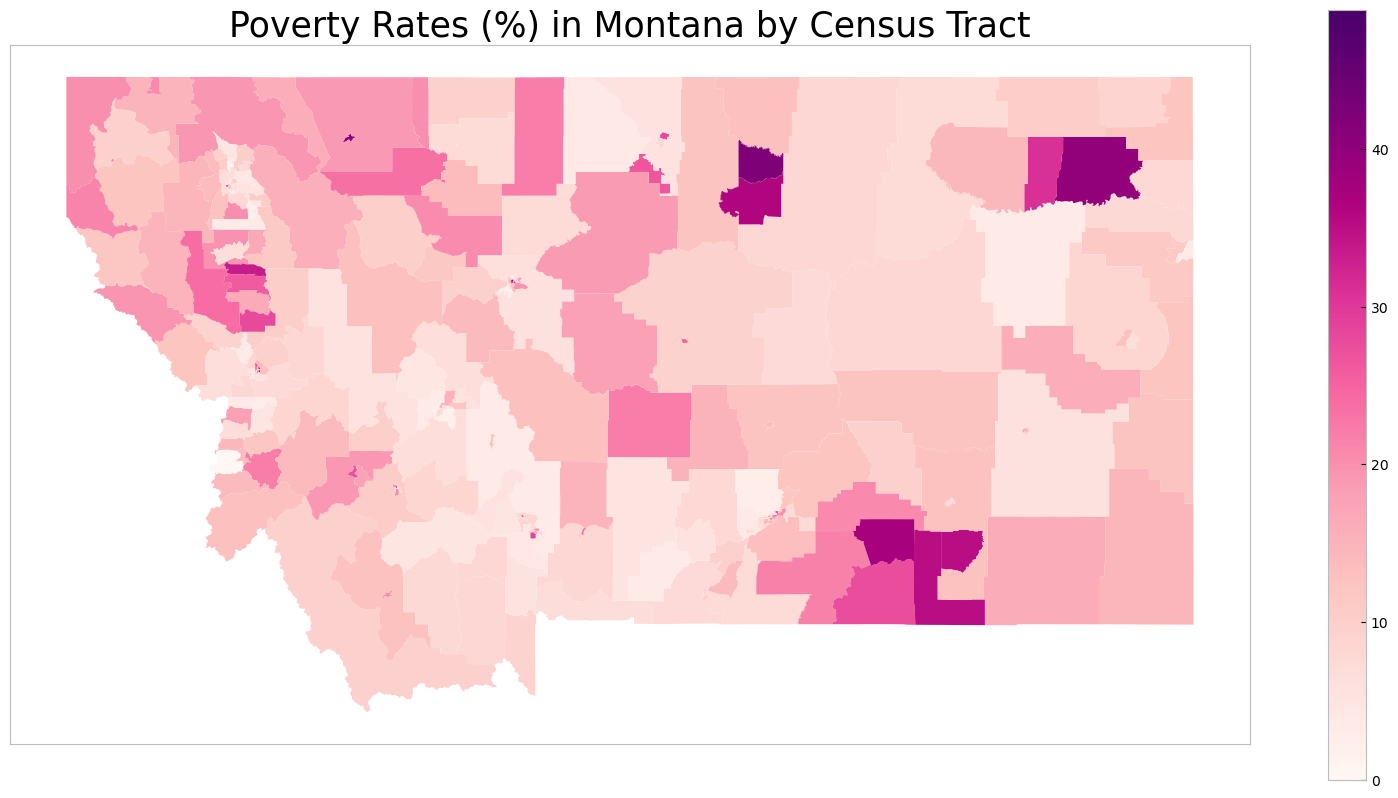

In [39]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
mt_poverty_tract.plot(column = 'Poverty_Rate', ax = ax, cmap = 'RdPu', legend=True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Montana by Census Tract', fontdict = {'fontsize': '25', 'fontweight' : '3'})

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Set background color
ax.set_facecolor('white')

### Spatial Aggregation
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

We may want to aggregate data to the county level. This is very easy to do with `GeoPandas` and uses a spatial [`dissolve`](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) methods just like ArcGIS or QGIS. In short, `dissolve` uses catagorical data to dissolve the boundaries between ajoining polygons with the same catagorical value. In this case, we will use the `COUNTYFP` code to disscolve the census tract level data. We will need to pass an aggregation method (see [here](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html). In this case, we'll use `sum`.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [21]:
# Dissolve data
mt_poverty_tract_d = mt_merge[["STATEFP", "COUNTYFP", "TRACTCE", 
                             "GEOID", "geometry", "C17002_001E", 
                             "C17002_002E", "C17002_003E", "B01003_001E"]].copy()
mt_poverty_county = mt_poverty_tract_d .dissolve(by = 'COUNTYFP', aggfunc = 'sum')
mt_poverty_county.head()

/Users/t61d992/miniconda3/envs/geo10/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E
COUNTYFP,,,,,
001,"POLYGON ((-113.93780 45.69669, -113.93760 45.6...",8895.0,493.0,973.0,9391.0
003,"POLYGON ((-107.01290 44.99641, -107.02009 44.9...",12952.0,1453.0,2247.0,13198.0
005,"POLYGON ((-108.41123 48.31547, -108.41123 48.3...",6953.0,1004.0,790.0,7051.0
007,"POLYGON ((-111.78795 46.56947, -111.78118 46.5...",6589.0,131.0,323.0,6641.0
009,"POLYGON ((-109.06312 44.99954, -109.06362 44.9...",10367.0,311.0,697.0,10488.0


In [ ]:
# Use the dataframe's shape to see how many counties there are in Montana

In [23]:
# Get poverty rate and store mtlues in new column
mt_poverty_county["Poverty_Rate"] = (mt_poverty_county["C17002_002E"] + 
                                     mt_poverty_county["C17002_003E"]) / mt_poverty_county["B01003_001E"] * 100

# Show dataframe
mt_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((-113.93780 45.69669, -113.93760 45.6...",8895.0,493.0,973.0,9391.0,15.610691
003,"POLYGON ((-107.01290 44.99641, -107.02009 44.9...",12952.0,1453.0,2247.0,13198.0,28.034551


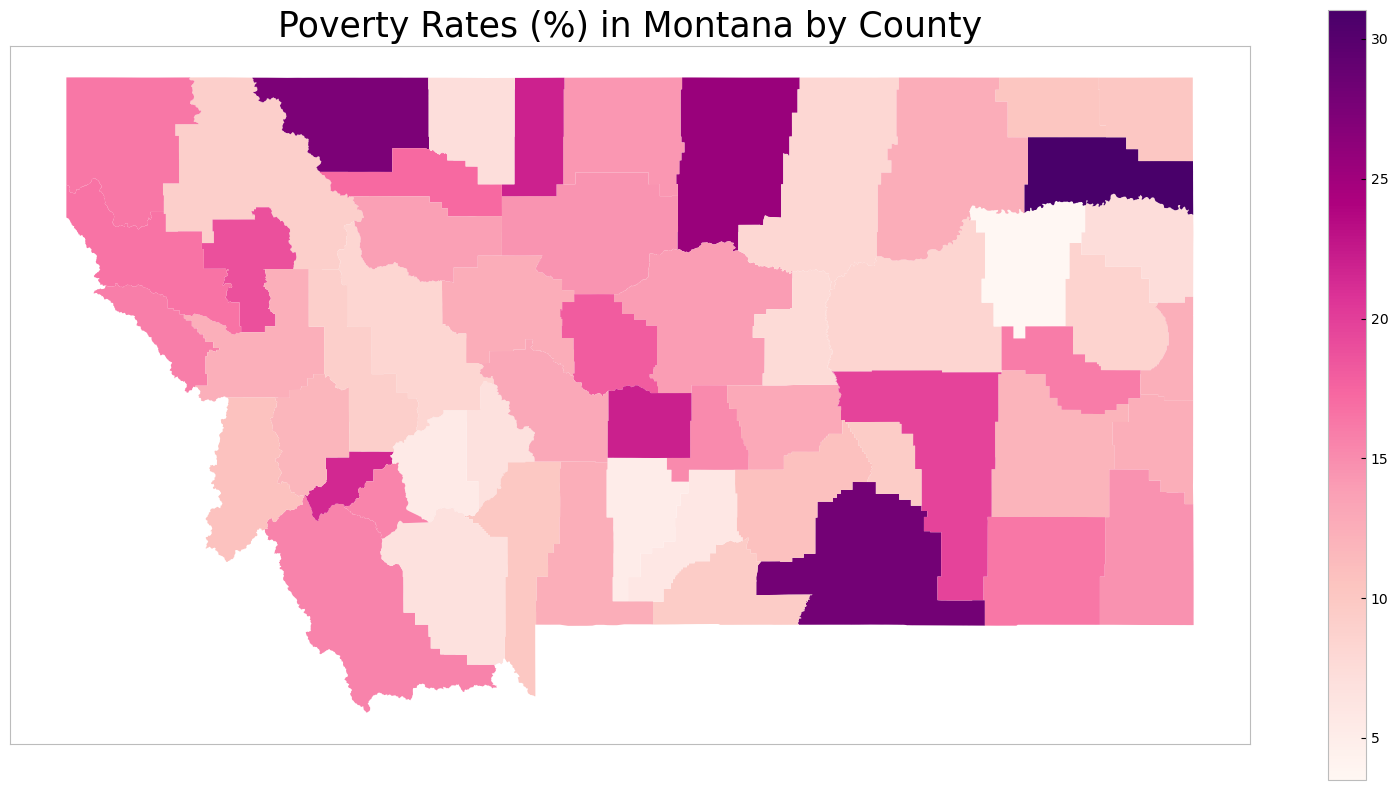

In [37]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
mt_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Montana by County', fontdict = {'fontsize': '25', 'fontweight' : '3'})

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Set background color
ax.set_facecolor('white')

### On Your Own
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

1. Pull down, make an API request to get the total white population and the total American Indian population at the census-tract level for Montana. You will need to read the US Census variable description sheet – [See here](https://api.census.gov/data/2022/acs/acs5/variables.html) – very carefully to find the correct column names.   <br><br>

2. After, at the census tract level, find the percent of the population that is white and the percentage that is American Indian.  <br><br>

3. Make census tract level maps of the percentage of white Montanans and American Indian Montanans.  <br><br>

4. Finally, make two scatter plots: (1) The census tract level relationship between Whites and poverty rates and American Indians and Poverty rates.  <br><br>